# VAJA 4 - Statistična analiza procesa – Bivariatni statistični testi

## Ustvarjanje nove podatkovne zbirke posodobljene

Trajanje_kategorija -> Trajanje_h (Nominalna kratko, srednje, dolgo)
* Omogoča primerjavo različnih dolžin korakov in njihovo povezavo z vrsto aktivnosti (VA/NVA/NNVA). Pomaga odkriti, ali so dolgi koraki povezani z napakami ali neučinkovitostjo.

Čakanje_kategorija -> Čakanje_h (Nominalna nizko, srednje, visoko)
* omogoča razvrščanje korakov glede na obseg čakanja in analizo, ali imajo nekatere vloge ali aktivnosti večje čakalne dobe. To razkrije ozka grla v procesu.

In [4]:
import numpy as np

'''
import pandas as pd

DATA_PATH = "Izdelava3DPrototipa_Baza_SKUPINE.xlsx"
df = pd.read_excel(DATA_PATH)

# Delete null or empty 'Korak' rows
df = df[~(df['Korak'].isna() | (df['Korak'].astype(str).str.strip() == ''))].copy()

for c in ["Trajanje_h", "Čakanje_h", "Napake"]:
    df[c] = pd.to_numeric(df[c], errors="coerce").fillna(0)

# Create new column 'Skupni_čas_h' as the sum of 'Trajanje_h' and 'Čakanje_h'
df["Skupni_čas_h"] = df["Trajanje_h"] + df["Čakanje_h"]

# Dodaj kategorije za trajanje
df["Trajanje_kategorija"] = pd.cut(
    df["Trajanje_h"],
    bins=[0, 1, 2, df["Trajanje_h"].max()],
    labels=["Kratko", "Srednje", "Dolgo"]
)

# Dodaj kategorije za čakanje
df["Čakanje_kategorija"] = pd.cut(
    df["Čakanje_h"],
    bins=[0, 0.5, 1, df["Čakanje_h"].max()],
    labels=["Nizko", "Srednje", "Visoko"]
)

#print(df[["Trajanje_h", "Trajanje_kategorija", "Čakanje_h", "Čakanje_kategorija"]].head(10))
df.to_excel("Izdelava3DPrototipa_Baza_SKUPINE_pripravljena.xlsx", index=False)
'''


In [3]:
import pandas as pd

DATA_PATH = "Izdelava3DPrototipa_Baza_SKUPINE_pripravljena.xlsx"
df = pd.read_excel(DATA_PATH)


## Preverjanje porazdelitve

V tem koraku preverimo ali imajo spremeljivke normalno porarazdelitev.
To vpliva na to, kateri statistični test boš uporabimo:
* če je normalna → uporabimo parametrične teste (Pearson, t-test, ANOVA),
* če ni normalna → uporabimo neparametrične teste (Spearman, Mann-Whitney, Kruskal-Wallis).


Spremenljivka: Trajanje_h


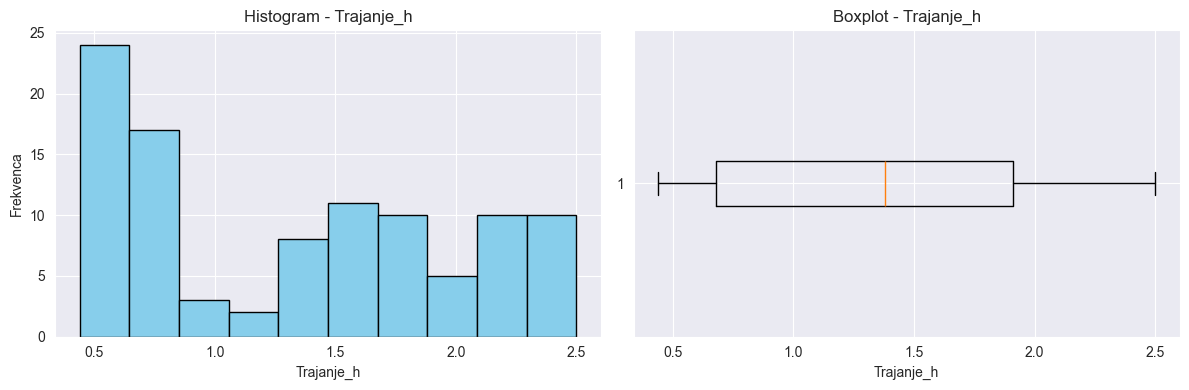

Shapiro–Wilk test: W = 0.901, p = 0.0000
➡ Porazdelitev NI normalna (p < 0.05)
Trajanje_h: večina vrednosti je med 1–2 h, nekaj ekstremov nad 3 h.

Spremenljivka: Čakanje_h


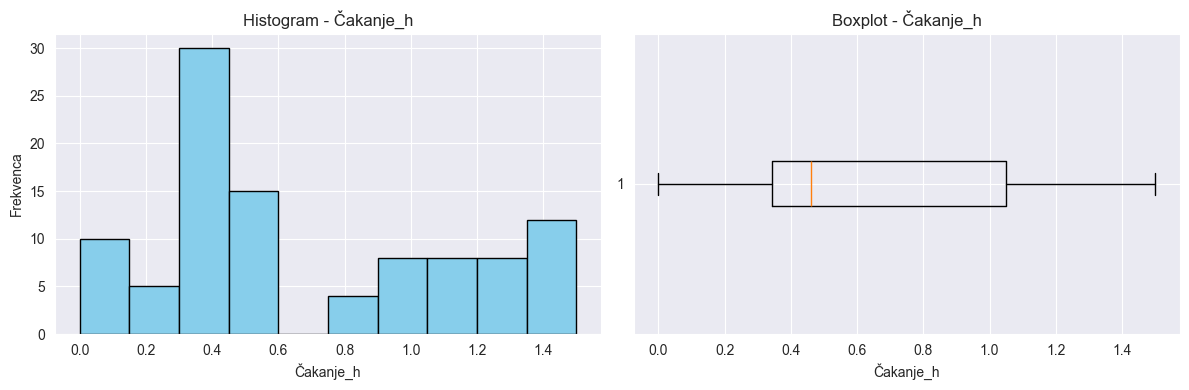

Shapiro–Wilk test: W = 0.900, p = 0.0000
➡ Porazdelitev NI normalna (p < 0.05)
Čakanje_h: večina čakanj je kratkih (<1 h), nekaj posameznih primerov nad 2 h.

Spremenljivka: Napake


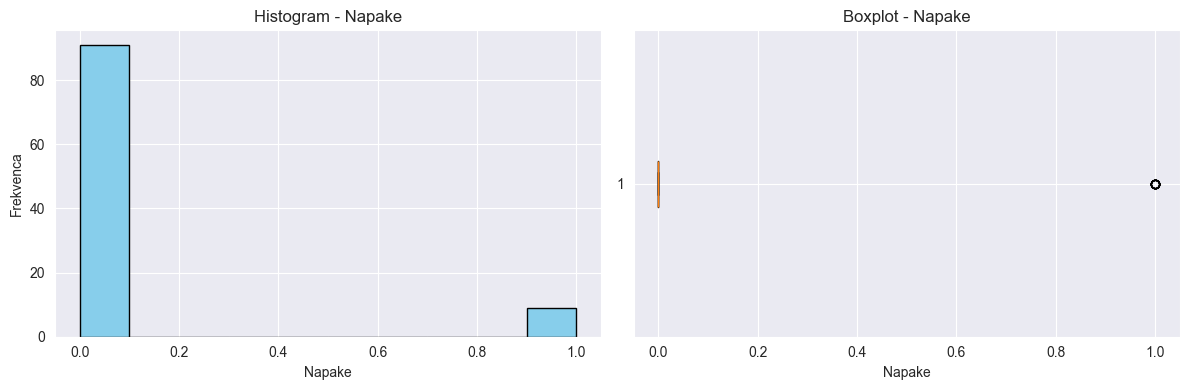

Shapiro–Wilk test: W = 0.322, p = 0.0000
➡ Porazdelitev NI normalna (p < 0.05)
Napake: večina korakov brez napak (0), le nekaj izjem ima vrednost 1 ali več.


In [4]:
from scipy.stats import shapiro
import matplotlib.pyplot as plt

numeric_vars = ['Trajanje_h', 'Čakanje_h', 'Napake']

for var in numeric_vars:
    print(f"\nSpremenljivka: {var}")

    # Histogram
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.hist(df[var], bins=10, color='skyblue', edgecolor='black')
    plt.title(f'Histogram - {var}')
    plt.xlabel(var)
    plt.ylabel('Frekvenca')

    # Boxplot
    plt.subplot(1,2,2)
    plt.boxplot(df[var], vert=False)
    plt.title(f'Boxplot - {var}')
    plt.xlabel(var)
    plt.tight_layout()
    plt.show()

    # Shapiro–Wilk test
    stat, p = shapiro(df[var])
    print(f"Shapiro–Wilk test: W = {stat:.3f}, p = {p:.4f}")

    if p >= 0.05:
        print("➡ Porazdelitev je približno normalna (p ≥ 0.05)")
    else:
        print("➡ Porazdelitev NI normalna (p < 0.05)")

    if var == 'Trajanje_h':
        print("Trajanje_h: večina vrednosti je med 1–2 h, nekaj ekstremov nad 3 h.")
    elif var == 'Čakanje_h':
        print("Čakanje_h: večina čakanj je kratkih (<1 h), nekaj posameznih primerov nad 2 h.")
    elif var == 'Napake':
        print("Napake: večina korakov brez napak (0), le nekaj izjem ima vrednost 1 ali več.")


Rezultati Shapiro–Wilk testa kažejo, da nobena od analiziranih spremenljivk nima normalne porazdelitve (p < 0.05).
To pomeni, da so podatki asimetrični in vsebujejo odstopanja (outlierje), kar je značilno za realne procese z različnim trajanjem in občasnimi napakami.

Trajanje_h: Histogram kaže večino vrednosti med 1 in 2 urama, nekaj posameznih daljših korakov nad 3 h.
→ To pomeni, da so nekateri postopki zahtevnejši in trajajo dlje, a večina je v standardnem časovnem okviru.

Čakanje_h: Distribucija je podobno nagnjena v levo — večina čakanj je krajša od 1 h, redko preseže 2 h.
→ To kaže na učinkovito planiranje, vendar obstajajo posamezna ozka grla.

Napake: Skoraj vsi koraki so brez napak, kar pomeni stabilen proces;
redke napake (vrednost 1 ali več) so verjetno posledica kompleksnih faz (tiskanje, kontrola kakovosti).

## STATISTIČNA ANALIZA

V tem delu analiziram medsebojne povezave in razlike med ključnimi spremenljivkami v procesu izdelave individualiziranega 3D implantata.
Namen statistične analize je preveriti, ali obstajajo povezave med kategorijami in numeričnimi podatki ter razlike med skupinami, ki bi lahko pojasnile vire neučinkovitosti v procesu.

Za analizo so bili uporabljeni naslednji testi:

* χ² (Chi-square test) za preverjanje povezanosti med dvema kategorialnima spremenljivkama,
* Spearmanov koeficient korelacije za preverjanje povezanosti med dvema numeričnima spremenljivkama (pri nenormalni porazdelitvi podatkov),
* Mann–Whitney U test za primerjavo razlik med dvema skupinama (VA in NVA aktivnosti),
* Kruskal–Wallis test za preverjanje razlik med več kot dvema skupinama (različne vloge v procesu).

Analiza temelji na predpostavkah o normalnosti porazdelitve, preverjenih s Shapiro–Wilkovim testom, zato so bili uporabljeni neparametrični testi, ki ne zahtevajo normalne porazdelitve podatkov.

Rezultati bodo predstavljeni z grafi, statističnimi vrednostmi (r, χ², U, H) in p-vrednostmi ter interpretirani v kontekstu učinkovitosti celotnega procesa.

### Test povezanosti dveh kategorialnih spremenljivk: χ² test

Ali obstaja povezava med vrsto aktivnosti (VA, NVA, NNVA) in dolžino trajanja (kratko, srednje, dolgo)?

***χ² (Chi-square test povezanosti)***
namenjen preverjanju, ali sta dve kategorialni spremenljivki medsebojno povezani.

Izbrane speemljivke:
* Tip_aktivnosti (kategorialna: VA, NVA, NNVA)
* Trajanje_kategorija (kategorialna: kratko, srednje, dolgo

Predpostavke:
* Obe spremenljivki sta kategorialni zato uporabimo χ² test.
* Vsaka kategorija ima dovolj opazovanj (>5 v pričakovanih vrednostih) → pogoj izpolnjen.
* Normalnost in homogenost varianc se pri kategorialnih podatkih ne preverjata (ni potrebno).

Kontingenčna tabela:
Trajanje_kategorija  Dolgo  Kratko  Srednje
Tip_aktivnosti                             
NNVA                     0       3        7
NVA                      0      40        0
VA                      20       0       30

Skupno število opazovanj: N = 100
χ² = 97.008, p < 0.001, stopnje svobode = 4
Cramér’s V = 0.696
Celice s pričakovano frekvenco < 5: 3/9
Velikost učinka: močna povezanost.
Obstaja statistično značilna povezava med tipom aktivnosti in dolžino trajanja.


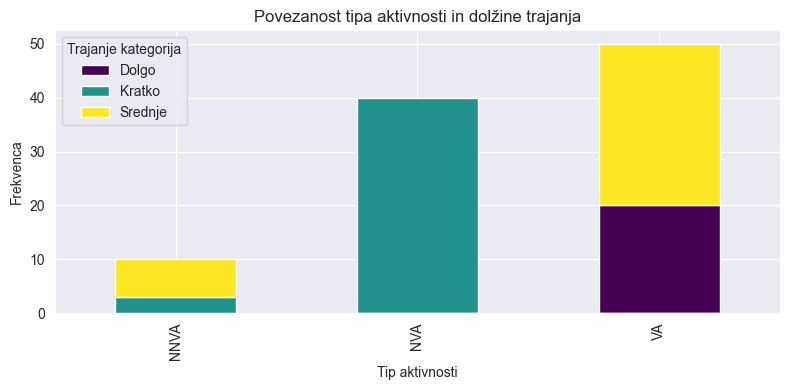

In [11]:
from scipy.stats import chi2_contingency
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Kontingenčna tabela
cont_table = pd.crosstab(df["Tip_aktivnosti"], df["Trajanje_kategorija"])
chi2, p, dof, expected = chi2_contingency(cont_table)

N = cont_table.to_numpy().sum()
k = min(cont_table.shape)
cramers_v = np.sqrt(chi2 / (N * (k - 1)))

p_text = "< 0.001" if p < 0.001 else f"= {p:.3f}"
under5 = (expected < 5).sum()

print("Kontingenčna tabela:")
print(cont_table)
print(f"\nSkupno število opazovanj: N = {N}")
print(f"χ² = {chi2:.3f}, p {p_text}, stopnje svobode = {dof}")
print(f"Cramér’s V = {cramers_v:.3f}")
print(f"Celice s pričakovano frekvenco < 5: {under5}/{expected.size}")

def interpret_cramers_v(v):
    if v < 0.1:
        return "zelo šibka"
    elif v < 0.3:
        return "šibka"
    elif v < 0.5:
        return "zmerna"
    else:
        return "močna"

print(f"Velikost učinka: {interpret_cramers_v(cramers_v)} povezanost.")

if p < 0.05:
    print("Obstaja statistično značilna povezava med tipom aktivnosti in dolžino trajanja.")
else:
    print("Ni statistično značilne povezave med tipom aktivnosti in dolžino trajanja.")

cont_table.plot(kind="bar", stacked=True, figsize=(8,4), colormap="viridis")
plt.title("Povezanost tipa aktivnosti in dolžine trajanja")
plt.xlabel("Tip aktivnosti")
plt.ylabel("Frekvenca")
plt.legend(title="Trajanje kategorija")
plt.tight_layout()
plt.show()

Rezultati kažejo, da obstaja statistično značilna povezava med tipom aktivnosti in dolžino trajanja (p < 0.001, Cramér’s V = 0.696 → močna povezanost)
To pomeni, da se različne vrste aktivnosti (VA, NVA, NNVA) pomembno razlikujejo po trajanju korakov:

* VA aktivnosti (dodana vrednost) so večinoma srednje ali dolge, kar je logično, saj vključujejo faze modeliranja in tiskanja, ki zahtevajo več časa.
* NVA aktivnosti so pretežno kratke, saj predstavljajo pomožne postopke, kot so administracija ali prenos podatkov.
* NNVA aktivnosti vključujejo nekaj srednjih korakov, ki ne dodajajo vrednosti, kot so popravki ali nepotrebni pregledi.

Ta rezultat potrjuje, da vrsta aktivnosti neposredno vpliva na dolžino trajanja, kar pomeni, da bi se optimizacija procesa morala osredotočiti na skrajševanje neproduktivnih (NVA/NNVA) faz

### Test povezanosti dveh numeričnih spremenljivk (Spearmanov test)
Ali obstaja povezava med dolžino trajanja posameznega koraka in časom čakanja v procesu izdelave 3D implantata?

***Spearmanov koeficient korelacije (rₛ)***
meri, kako močno in v katero smer sta dve spremenljivki povezani (od -1 do +1).

Izbrane spremenljivke
* Trajanje_h → skupni čas izvajanja aktivnosti (v urah)
* Čakanje_h → čas čakanja med posameznimi koraki (v urah)

Predpostavke
* Obe spremenljivki sta numerični.
* Porazdelitev ni normalna (Shapiro–Wilkov test p < 0.05  potrjeno že v prejšnji analizi).
zato uporabimo neparametrični Spearmanov test korelacije (ne Pearsonovega).


Spearmanov koeficient korelacije rₛ = -0.445, p < 0.001
Število opazovanj: N = 100
Korelacija je negativna in zmerna (rₛ = -0.45).
Povezava med trajanjem in čakanjem je statistično značilna.


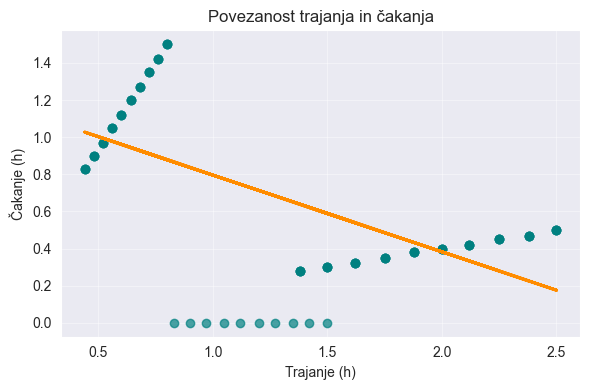

In [14]:
from scipy.stats import spearmanr
import matplotlib.pyplot as plt

# Izračun korelacije
x = df["Trajanje_h"]
y = df["Čakanje_h"]
r, p = spearmanr(x, y)
N = len(df)

print(f"Spearmanov koeficient korelacije rₛ = {r:.3f}, p {p_text}")
print(f"Število opazovanj: N = {N}")

def interpret_strength(r):
    r_abs = abs(r)
    if r_abs < 0.1:
        return "zelo šibka"
    elif r_abs < 0.3:
        return "šibka"
    elif r_abs < 0.5:
        return "zmerna"
    elif r_abs < 0.7:
        return "zmerno močna"
    else:
        return "močna"

trend = "pozitivna" if r > 0 else "negativna"
print(f"Korelacija je {trend} in {interpret_strength(r)} (rₛ = {r:.2f}).")

if p < 0.05:
    print("Povezava med trajanjem in čakanjem je statistično značilna.")
else:
    print("Povezava ni statistično značilna (p ≥ 0.05).")

plt.figure(figsize=(6,4))
plt.scatter(df["Trajanje_h"], df["Čakanje_h"], alpha=0.7, color="teal")
m, b = np.polyfit(df["Trajanje_h"], df["Čakanje_h"], 1)  # regresijska črta
plt.plot(df["Trajanje_h"], m*df["Trajanje_h"] + b, color="darkorange", linewidth=2)
plt.title("Povezanost trajanja in čakanja")
plt.xlabel("Trajanje (h)")
plt.ylabel("Čakanje (h)")
plt.grid(alpha=0.4)
plt.tight_layout()
plt.show()

Graf prikazuje rahlo padajoč trend — krajši koraki so pogosto povezani z daljšim čakanjem, medtem ko so daljši koraki bolj kontinuirani in vključujejo manj čakalnega časa.

Rezultati kažejo na zmerno negativno povezanost med trajanjem in čakanjem (rₛ = –0.445, p < 0.001).
To pomeni, da daljši koraki praviloma vključujejo manj čakanja, medtem ko se pri krajših korakih pogosto pojavljajo prekinitve ali čakanja med postopki (npr. pri vmesnih odobritvah ali čakanju na rezultate).

V kontekstu procesa 3D tiskanja to nakazuje, da se večina izgub pojavlja pri krajših, podpornih aktivnostih (NVA/NNVA), medtem ko so daljši koraki (npr. tiskanje, modeliranje) bolj tekoči in manj prekinjeni.

### Test razlik med dvema skupinama

Ali se čas čakanja razlikuje med aktivnostmi z dodano vrednostjo (VA) in tistimi brez dodane vrednosti (NVA + NNVA)?

Mann–Whitney U test (neparametrični ekvivalent t-testa)
preverja, ali se distribucije (medianne vrednosti) dveh skupin statistično razlikujejo.

Izbrane spremenljivke
Neodvisna spremenljivka (skupine):

Tip aktivnosti → dve skupini:
 * VA (vrednost dodana)
 * NVA + NNVA (brez dodane vrednosti ali nepotrebne aktivnosti)

Odvisna spremenljivka:
* Čakanje_h (čas čakanja v urah)

Predpostavke
* Čakanje_h ni normalno porazdeljeno (p < 0.05, Shapiro–Wilk)
zato uporabimo neparametrični Mann–Whitney U test, ker primerjamo dve neodvisni skupini.
* Homogenost varianc ni pogoj za ta test.

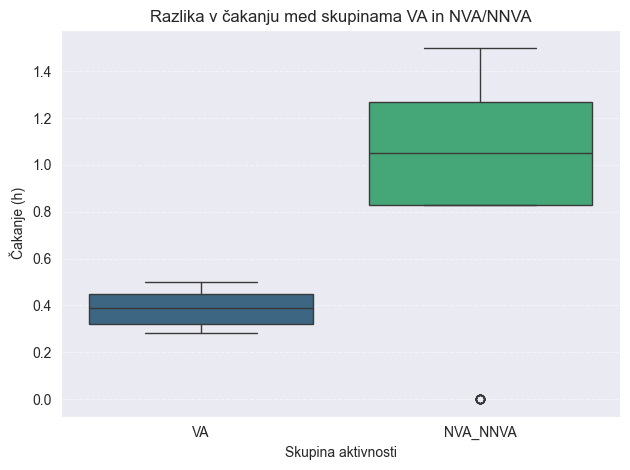

Mann–Whitney U test: U = 500.000, p < 0.001
Skupina VA: n₁ = 50, mediana = 0.39 h
Skupina NVA/NNVA: n₂ = 50, mediana = 1.05 h
Obstaja statistično značilna razlika v čakalnem času med skupinama.


In [16]:
import seaborn as sns
from scipy.stats import mannwhitneyu
import numpy as np
import matplotlib.pyplot as plt

# Priprava skupin
df['Skupina'] = df['Tip_aktivnosti'].apply(lambda x: 'VA' if x == 'VA' else 'NVA_NNVA')

va = df[df['Skupina'] == 'VA']['Čakanje_h']
nva = df[df['Skupina'] == 'NVA_NNVA']['Čakanje_h']

# Grafični prikaz
sns.boxplot(x='Skupina', y='Čakanje_h', hue='Skupina', data=df, palette='viridis', legend=False)
plt.title('Razlika v čakanju med skupinama VA in NVA/NNVA')
plt.xlabel('Skupina aktivnosti')
plt.ylabel('Čakanje (h)')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Mann–Whitney U test
stat, p = mannwhitneyu(va, nva, alternative='two-sided')
N1, N2 = len(va), len(nva)

p_text = "< 0.001" if p < 0.001 else f"= {p:.3f}"

print(f"Mann–Whitney U test: U = {stat:.3f}, p {p_text}")
print(f"Skupina VA: n₁ = {N1}, mediana = {np.median(va):.2f} h")
print(f"Skupina NVA/NNVA: n₂ = {N2}, mediana = {np.median(nva):.2f} h")

if p < 0.05:
    print("Obstaja statistično značilna razlika v čakalnem času med skupinama.")
else:
    print("Ni statistično značilne razlike v čakalnem času med skupinama.")



Na grafu so prikazani čakalni časi (v urah) za dve skupini aktivnosti:
* VA (Value Added) – aktivnosti, ki neposredno prispevajo k izdelku ali storitvi
* NVA/NNVA (Non-Value Added / Necessary Non-Value Added) – podporne ali nepotrebne aktivnosti, ki ne dodajajo vrednosti

Skupina VA ima nižjo mediano čakanja (≈0.4 h) in zelo majhen razpon vrednosti (vse aktivnosti potekajo dokaj tekoče).

Skupina NVA/NNVA ima višjo mediano (≈1.0 h) in večjo razpršenost, kar pomeni, da so te aktivnosti pogosto povezane z daljšimi čakalnimi časi.

Vidimo tudi outlier (izstopajočo vrednost) pri NVA/NNVA – to kaže, da je bilo v nekem primeru čakanje izjemno dolgo (verjetno pri odobritvah ali preverjanju kakovosti).

### Test razlik med več kot dvema skupinama

Ali se čas trajanja aktivnosti (Trajanje_h) razlikuje med različnimi vlogami v procesu izdelave 3D prototipa?

Kruskal–Wallis test (neparametrični ekvivalent ANOVE)
uporabimo, kadar primerjamo tri ali več neodvisnih skupin, pri čemer podatki niso normalno porazdeljeni.

Izbrane spremenljivke
Neodvisna spremenljivka (skupine):
* Vloga (kdo) → več skupin (npr. Raziskovalec, Kontrolor kakovosti, Vodja laboratorija, …)

Odvisna spremenljivka:
* Trajanje_h (čas izvajanja aktivnosti v urah)

Predpostavke
* Shapiro–Wilk test kaže, da spremenljivka Trajanje_h ni normalno porazdeljena pri večini vlog (npr. Raziskovalec: p = 0.014; Sistem/tiskalnik: p = 0.012).
* Zato uporabimo Kruskal–Wallis test, ki primerja mediane med več skupinami brez predpostavke normalnosti.
* Podatki so neodvisni (vsaka vloga predstavlja ločen sklop aktivnosti).

Preverjanje normalnosti po vlogah:

Kontrolor kakovosti: W = 0.970, p = 0.892
Porazdelitev je približno normalna (p ≥ 0.05)

Raziskovalec: W = 0.949, p = 0.014
Porazdelitev NI normalna (p < 0.05)

Sistem/tiskalnik: W = 0.871, p = 0.012
Porazdelitev NI normalna (p < 0.05)

Vodja laboratorija: W = 0.970, p = 0.892
Porazdelitev je približno normalna (p ≥ 0.05)


Kruskal–Wallis test:
Število skupin: 4, Skupno število opazovanj: N = 100
H = 30.037, p < 0.001
Obstajajo statistično značilne razlike v trajanju med vlogami.


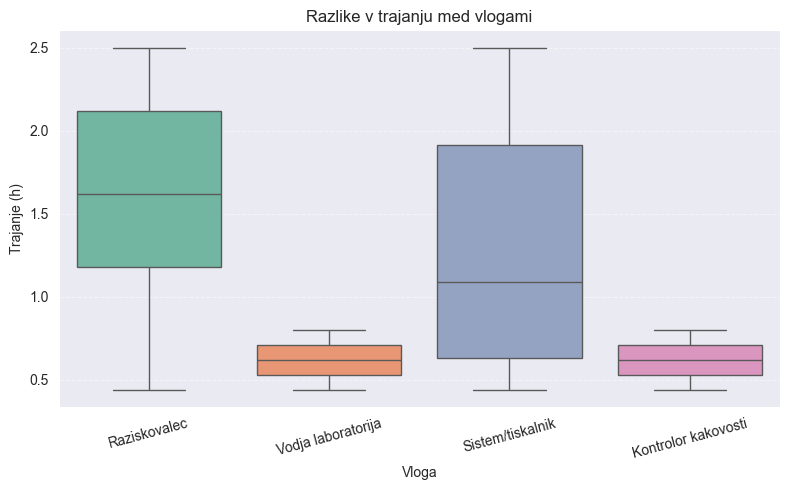

In [17]:
from scipy.stats import shapiro, kruskal
import seaborn as sns
import matplotlib.pyplot as plt

# Preverjanje normalnosti po vlogah
groups = df.groupby('Vloga (kdo)')['Trajanje_h']
print("Preverjanje normalnosti po vlogah:\n")
for name, values in groups:
    stat, p = shapiro(values)
    p_text = "< 0.001" if p < 0.001 else f"= {p:.3f}"
    print(f"{name}: W = {stat:.3f}, p {p_text}")
    if p < 0.05:
        print("Porazdelitev NI normalna (p < 0.05)\n")
    else:
        print("Porazdelitev je približno normalna (p ≥ 0.05)\n")

# Kruskal–Wallis test (če podatki niso normalni)
grouped_data = [values for name, values in groups]
names = [name for name, values in groups]
stat, p = kruskal(*grouped_data)
p_text = "< 0.001" if p < 0.001 else f"= {p:.3f}"

N = len(df)
k = len(groups)
print("\nKruskal–Wallis test:")
print(f"Število skupin: {k}, Skupno število opazovanj: N = {N}")
print(f"H = {stat:.3f}, p {p_text}")

if p < 0.05:
    print("Obstajajo statistično značilne razlike v trajanju med vlogami.")
else:
    print("Ni statistično značilnih razlik v trajanju med vlogami.")

# Boxplot
plt.figure(figsize=(8,5))
sns.boxplot(x='Vloga (kdo)', y='Trajanje_h', data=df, hue='Vloga (kdo)', legend=False, palette='Set2')
plt.title('Razlike v trajanju med vlogami')
plt.xlabel('Vloga')
plt.ylabel('Trajanje (h)')
plt.xticks(rotation=15)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


***Kaj pomeni H = 30.037***
To je vrednost testne statistike (H), ki jo izračuna Kruskal–Wallis test.
Podobno kot pri ANOVI meri, koliko se mediane (oz. porazdelitve) med skupinami razlikujejo.

* Višja vrednost H pomeni, da so razlike med skupinami večje.
Če bi bile vse skupine zelo podobne (npr. vse vloge bi imele skoraj enak čas trajanja), bi bil H blizu 0.

***Kaj pomeni p = 0.000***
To je p-vrednost, ki pove, kako verjetno bi dobili tako velike razlike, če v resnici ni nobene razlike (če bi vse vloge imele enako povprečje/mediano).
* V tvojem primeru je p < 0.001, kar pomeni:
Verjetnost, da so razlike med vlogami nastale po naključju, je manjša od 0.1 %.



Na boxplotu vidimo, da imajo:
* Raziskovalec in Sistem/tiskalnik najdaljše trajanje aktivnosti (mediana približno 1.5–2 h),
* medtem ko imata Vodja laboratorija in Kontrolor kakovosti krajše trajanje (pod 1 h).

To pomeni, da je časovna obremenitev v procesu neenakomerno porazdeljena,
pri čemer večina operativnega dela poteka pri raziskovalcih in tehnikih (sistem/tiskalnik),
medtem ko podporne vloge (vodja, kontrolor) izvajajo krajše, a pogoste aktivnosti.